# Dog Breed Classification using InceptionV3 CNN Model on Stanford Dogs Dataset
<!-- ## Abstract -->
The Stanford Dogs dataset contains images of 120 breeds of dogs from around the world. This dataset has been built using images and annotation from ImageNet for the task of fine-grained image categorization. It was originally collected for fine-grain image categorization, a challenging problem as certain dog breeds have near identical features or differ in colour and age.

I have used the InceptionV3 CNN Model, which is pre-trained on the ImageNet dataset for classification. Data augementation has been used for making the model generalize better and also to avoid overfitting. The model achieved an accuracy of 80% on validation set, which is decent enough for this dataset.

# Installing and Importing Libraries

In [5]:
import os
import pandas as pd
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize
from IPython.display import SVG
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

# Dataset

In [6]:
train_data_dir = "./data/dog-images/"
img_width, img_height = 224, 224 
channels = 3
batch_size = 64
num_images= 50
image_arr_size= img_width * img_height * channels

In [7]:
def get_images(image_dir):

    image_index = 0
    image_arr_size= img_width * img_height * channels
    images = np.ndarray(shape=(num_images, image_arr_size))
    labels = np.array([])                       

    for type in os.listdir(image_dir)[:50]:
        type_images = os.listdir(image_dir + type)
        labels= np.append(labels, type.split('-')[1])
        
        for image in type_images[:1]:
            image_file = os.path.join(image_dir, type + '/', image)
            image_data = mpimg.imread(image_file)
            image_resized = resize(image_data, (img_width, img_height), anti_aliasing=True)
            images[image_index, :] = image_resized.flatten()
            print (type, ':', image)
            image_index += 1

    return (images, labels)

def plot_images(instances, images_per_row=10, **options):
    size = img_width
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(img_width, img_height, channels) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((img_width, img_height * n_empty)))
    for row in range(n_rows):
        if (row == len(instances)/images_per_row):
            break
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.figure(figsize=(20,20))
    plt.imshow(image, **options)
    plt.axis("off")
    plt.savefig('dogs_images.png', transparent= True, bbox_inches= 'tight', dpi= 900)
    plt.show()

n02097658-silky_terrier : n02097658_26.jpg
n02092002-Scottish_deerhound : n02092002_2981.jpg
n02099849-Chesapeake_Bay_retriever : n02099849_435.jpg
n02091244-Ibizan_hound : n02091244_2782.jpg
n02095314-wire-haired_fox_terrier : n02095314_3084.jpg
n02091831-Saluki : n02091831_256.jpg
n02102318-cocker_spaniel : n02102318_8482.jpg
n02104365-schipperke : n02104365_6395.jpg
n02090622-borzoi : n02090622_906.jpg
n02113023-Pembroke : n02113023_6548.jpg
n02105505-komondor : n02105505_4325.jpg
n02093256-Staffordshire_bullterrier : n02093256_14608.jpg
n02113799-standard_poodle : n02113799_5009.jpg
n02109961-Eskimo_dog : n02109961_16718.jpg
n02089973-English_foxhound : n02089973_811.jpg
n02099601-golden_retriever : n02099601_1028.jpg
n02095889-Sealyham_terrier : n02095889_2204.jpg
n02085782-Japanese_spaniel : n02085782_919.jpg
n02097047-miniature_schnauzer : n02097047_2470.jpg
n02110063-malamute : n02110063_4432.jpg
n02105162-malinois : n02105162_7790.jpg
n02086079-Pekinese : n02086079_12125.jpg
n

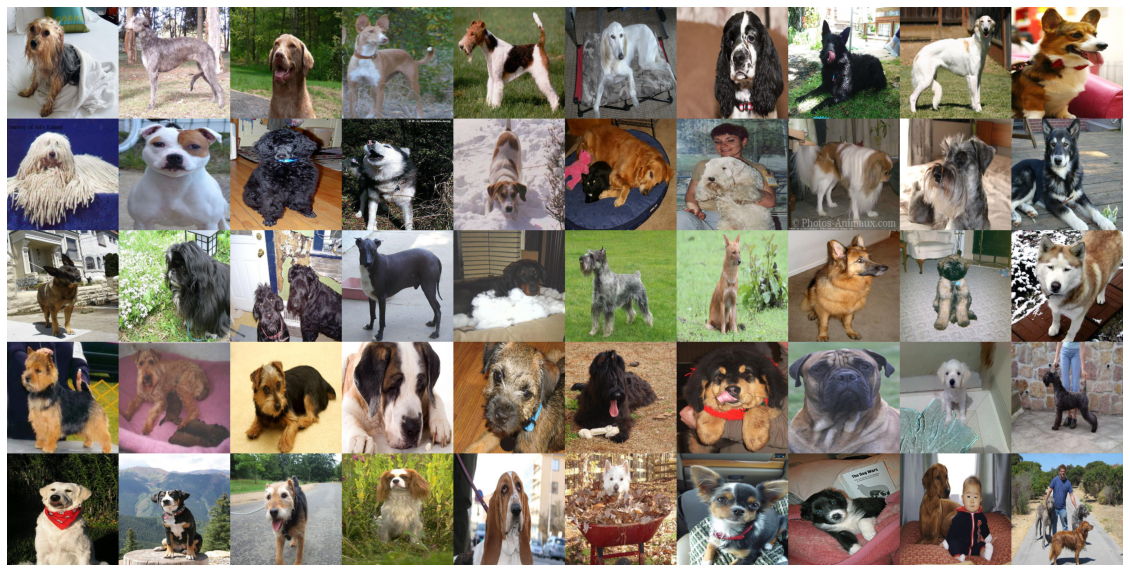

In [8]:
images, labels = get_images(train_data_dir)
plot_images(images)

# Preprocessing

In [9]:
train_datagen = ImageDataGenerator(
    rescale= 1./255, #Dados serão multiplicados por este valor após aplicar os outros filtros
    shear_range= 0.2, #Em graus, sentido horário
    zoom_range= 0.2, #Random
    horizontal_flip= True, #Espelhamento Random
    rotation_range= 20, #Random
    width_shift_range= 0.2, #Fração da largura total 
    height_shift_range= 0.2,  #Fração da altura total 
    validation_split=0.2, #Fração de imagens reservadas para validação

)

valid_datagen = ImageDataGenerator(
    rescale= 1./255,
    validation_split=0.2,
)


In [10]:
train_generator = train_datagen.flow_from_directory(  
    train_data_dir,  #Diretório
    target_size= (img_width, img_height), #Tamanho para o qual as imagens serão convertidas
    color_mode= 'rgb', 
    batch_size= batch_size,  #Tamanho dos lotes
    class_mode= 'categorical', #Tipo de array de rótulo retornado
    subset='training', #Tipo de dado
    shuffle= True, #Embaralhamento
    seed= 1337 #Seed opcional para embaralhamento e transformações
) 
classes = train_generator.class_indices    
print(classes)

valid_generator = valid_datagen.flow_from_directory(
    train_data_dir,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    subset='validation',
    shuffle= True, 
    seed= 1337
)

Found 16508 images belonging to 120 classes.
{'n02085620-Chihuahua': 0, 'n02085782-Japanese_spaniel': 1, 'n02085936-Maltese_dog': 2, 'n02086079-Pekinese': 3, 'n02086240-Shih-Tzu': 4, 'n02086646-Blenheim_spaniel': 5, 'n02086910-papillon': 6, 'n02087046-toy_terrier': 7, 'n02087394-Rhodesian_ridgeback': 8, 'n02088094-Afghan_hound': 9, 'n02088238-basset': 10, 'n02088364-beagle': 11, 'n02088466-bloodhound': 12, 'n02088632-bluetick': 13, 'n02089078-black-and-tan_coonhound': 14, 'n02089867-Walker_hound': 15, 'n02089973-English_foxhound': 16, 'n02090379-redbone': 17, 'n02090622-borzoi': 18, 'n02090721-Irish_wolfhound': 19, 'n02091032-Italian_greyhound': 20, 'n02091134-whippet': 21, 'n02091244-Ibizan_hound': 22, 'n02091467-Norwegian_elkhound': 23, 'n02091635-otterhound': 24, 'n02091831-Saluki': 25, 'n02092002-Scottish_deerhound': 26, 'n02092339-Weimaraner': 27, 'n02093256-Staffordshire_bullterrier': 28, 'n02093428-American_Staffordshire_terrier': 29, 'n02093647-Bedlington_terrier': 30, 'n020937

In [11]:
num_classes = len(train_generator.class_indices)  #classes e seus indíces
train_labels = train_generator.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)

valid_labels = valid_generator.classes 
valid_labels = to_categorical(valid_labels, num_classes=num_classes)
nb_train_samples = len(train_generator.filenames)  
nb_valid_samples = len(valid_generator.filenames)

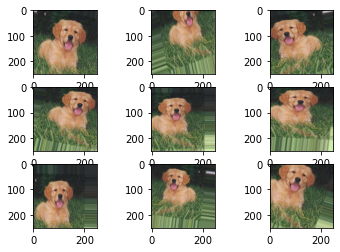

In [12]:
img = load_img('./data/dog-images/n02099601-golden_retriever/n02099601_5.jpg')
data = img_to_array(img) #Converte a imagem em um numpy array
samples = expand_dims(data, 0) #insere uma dimensão de 
#comprimento 1 no eixo do índice de dimensão da forma da entrada
it = train_datagen.flow(samples, batch_size=1) #Gera lotes de imagem

for i in range(9): #Imagens transformadas
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0]
    plt.imshow(image) #Cria o exemplo abaixo das imagens

plt.savefig('augmented_image.png', transparent= False, bbox_inches= 'tight', dpi= 900)
plt.show()

# Model

In [13]:
InceptionV3 = applications.InceptionV3(include_top= False, input_shape= (img_width, img_height, channels), weights= 'imagenet')
InceptionV3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [14]:
model = Sequential()

for layer in InceptionV3.layers:
    layer.trainable= False
#     print(layer,layer.trainable)
    
model.add(InceptionV3)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(120,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 120)               245880    
                                                                 
Total params: 22,048,664
Trainable params: 245,880
Non-trainable params: 21,802,784
_________________________________________________________________


In [15]:
#SVG(model_to_dot(model).create(prog='dot', format='svg'))
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

# Baseline Model Training

In [16]:
model.compile(optimizer= keras.optimizers.Adam(lr= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

/Users/gabriel.mansano/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [17]:
checkpoint = ModelCheckpoint(
    'baseline_model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    period=1
)

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto'
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint, earlystop, csvlogger,reduceLR]

In [ ]:
history = model.fit(
    train_generator, 
    epochs = 8,
    steps_per_epoch = nb_train_samples//batch_size,
    validation_data = valid_generator, 
    validation_steps = nb_valid_samples//batch_size,
    verbose = 2, 
    callbacks = callbacks,
    shuffle = True
)

Epoch 1/8

Epoch 1: val_loss improved from inf to 1.76525, saving model to baseline_model.h5
257/257 - 514s - loss: 3.4641 - accuracy: 0.2840 - val_loss: 1.7653 - val_accuracy: 0.6687 - lr: 1.0000e-04 - 514s/epoch - 2s/step
Epoch 2/8

Epoch 2: val_loss improved from 1.76525 to 0.99689, saving model to baseline_model.h5
257/257 - 519s - loss: 1.6175 - accuracy: 0.6258 - val_loss: 0.9969 - val_accuracy: 0.7597 - lr: 1.0000e-04 - 519s/epoch - 2s/step
Epoch 3/8

Epoch 3: val_loss improved from 0.99689 to 0.80875, saving model to baseline_model.h5
257/257 - 498s - loss: 1.1835 - accuracy: 0.6895 - val_loss: 0.8088 - val_accuracy: 0.7840 - lr: 1.0000e-04 - 498s/epoch - 2s/step
Epoch 4/8

Epoch 4: val_loss improved from 0.80875 to 0.74511, saving model to baseline_model.h5
257/257 - 498s - loss: 1.0436 - accuracy: 0.7139 - val_loss: 0.7451 - val_accuracy: 0.7924 - lr: 1.0000e-04 - 498s/epoch - 2s/step
Epoch 5/8

Epoch 5: val_loss improved from 0.74511 to 0.70595, saving model to baseline_mode

In [ ]:
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [22]:
from keras.models import load_model

model = load_model('baseline_model.h5')

In [23]:
(eval_loss, eval_accuracy) = model.evaluate(valid_generator, batch_size= batch_size, verbose= 1)
print(valid_generator)
print('Validation Loss: ', eval_loss)
print('Validation Accuracy: ', eval_accuracy)

64/64 [==============================] - 89s 1s/step - loss: 0.6601 - accuracy: 0.8030
Validation Loss:  0.6600719094276428
Validation Accuracy:  0.8030452132225037


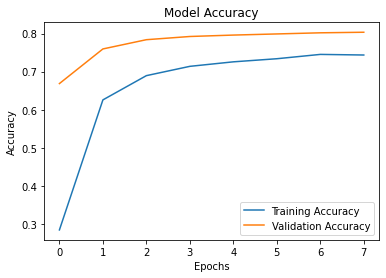

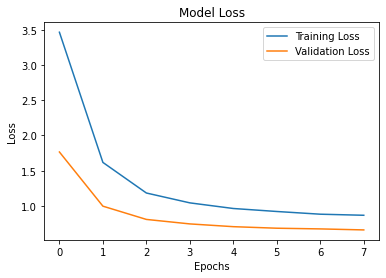

In [17]:
plt.subplot()
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.savefig('baseline_acc_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 900)
plt.show()

plt.title('Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.savefig('baseline_loss_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 900)
plt.show()

In [19]:
def predict(image):
    print(model.predict(image).shape)

In [20]:
def get_image(image_dir):

    image_index = 0
    image_arr_size= img_width * img_height * channels
    images = np.ndarray(shape=(num_images, image_arr_size))                   

    image_file = image_dir
    image_data = mpimg.imread(image_file)
    image_resized = resize(image_data, (img_width, img_height), anti_aliasing=True)
    images[image_index, :] = image_resized.flatten()
    #print (type, ':', image)

    return (images)

In [24]:
import PySimpleGUI as sg
from tkinter import filedialog
from PIL import Image
import cv2
import matplotlib.image as mpimg
from keras.models import load_model
import re

layout = [[sg.Text("Bem vindo ao identificador de raças de cachorro", size=(40,5), font=("Arial",22))], [sg.Image(key='-OUT-')], [sg.Text(key='-CLASS-', size=(40,2), font=("Arial", 30), justification="center")], [sg.Text(size=(40,5))], [sg.Text("Por favor insira uma imagem para ser identificada: ")], [sg.Button("Selecionar imagem")]]
model = load_model('baseline_model.h5')
# Create the window
window = sg.Window("Identificador de raças de cachorro", layout, element_justification='c')

# Create an event loop
while True:
    event, values = window.read()
    
    if event == "Selecionar imagem":
        filename = filedialog.askopenfilename()
        img = Image.open(filename).resize((400,400), Image.ANTIALIAS)
        img.save(fp="newimage.png")

        img=cv2.imread (filename)
        img=img/255
        img=cv2.resize(img, (224,224))
        img=np.expand_dims(img, axis=0)

        predict1 = model.predict(img)
        classes_x = np.argmax(predict1, axis=1)
        print(classes_x[0])

        j = 0

        for i in classes:
            if j == classes_x[0]:
                classe = re.sub("^[^-]*-", "", i)
                window['-CLASS-'].update(classe)
                break
            j += 1



        window['-OUT-'].update("newimage.png", size=(400,400))

    if event == sg.WIN_CLOSED:
        break

window.close()